<a href="https://colab.research.google.com/github/abhirup-ghosh/facial-expression-classifier-app/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Facial Emotion Recognition Predictor

**This notebook was run on Google Colab. To re-run in the exact environment, please click on the Google Colab link on the top-left.**

## Dependencies

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow.lite as tflite
from tensorflow.keras.preprocessing.image import load_img


import pickle

sns.set_style("whitegrid")
sns.set_palette('muted')

In [2]:
for package in [pd, np, mpl, sns, sklearn, pickle, tf]:
    if package == pickle: print(f'{package.__name__:<12}: {package.format_version}')
    else: print(f'{package.__name__:<12}: {package.__version__}')

pandas      : 1.5.3
numpy       : 1.23.5
matplotlib  : 3.7.1
seaborn     : 0.12.2
sklearn     : 1.2.2
pickle      : 4.0
tensorflow  : 2.15.0


In [3]:
tf.keras.utils.set_random_seed(42)

## Data Loading

The Kaggle dataset for this project can be downloaded from:
```
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
```

Details of the dataset, including description of columns and associated datatypes, can be found [here](../data/README.md).

* Load all the data
* Separate into image arrays and labels
* Separate into training, validation and test sets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')
#data = pd.read_csv('../data/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
data.columns = data.columns.str.strip()

## Data preprocessing

* separate input data into image arrays and labels
* define shape of input image array, emotion class labels (0 to 7) and number of classes (7)
* separate data into training, validation and test sets
* rescale images
* one-hot-encode target classes



In [6]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
      try:
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
      except ValueError: continue

    return image_array, image_label

In [7]:
# shape of input image arrays
input_shape = (48,48,1)

# emotion/class labels and number of classes
class_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
class_dict = dict(zip(range(7),class_labels))
num_classes = len(class_labels)

In [8]:
# separate image arrays into training, validation and test sets
# use 'Usage' tags: Training, PublicTest and PrivateTest respectively

train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PublicTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PrivateTest'])

In [9]:
# rescale image arrays

train_image_array = train_image_array/255.
val_image_array = val_image_array/255.
test_image_array = test_image_array/255.

In [10]:
# one hot encode target classes

y_train_one_hot = tf.keras.utils.to_categorical(train_image_label, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(val_image_label, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(test_image_label, num_classes=num_classes)

## EDA

* Imbalanced dataset: all emotions not equally represented, especially 'Disgust'

Text(0.5, 1.0, 'Test')

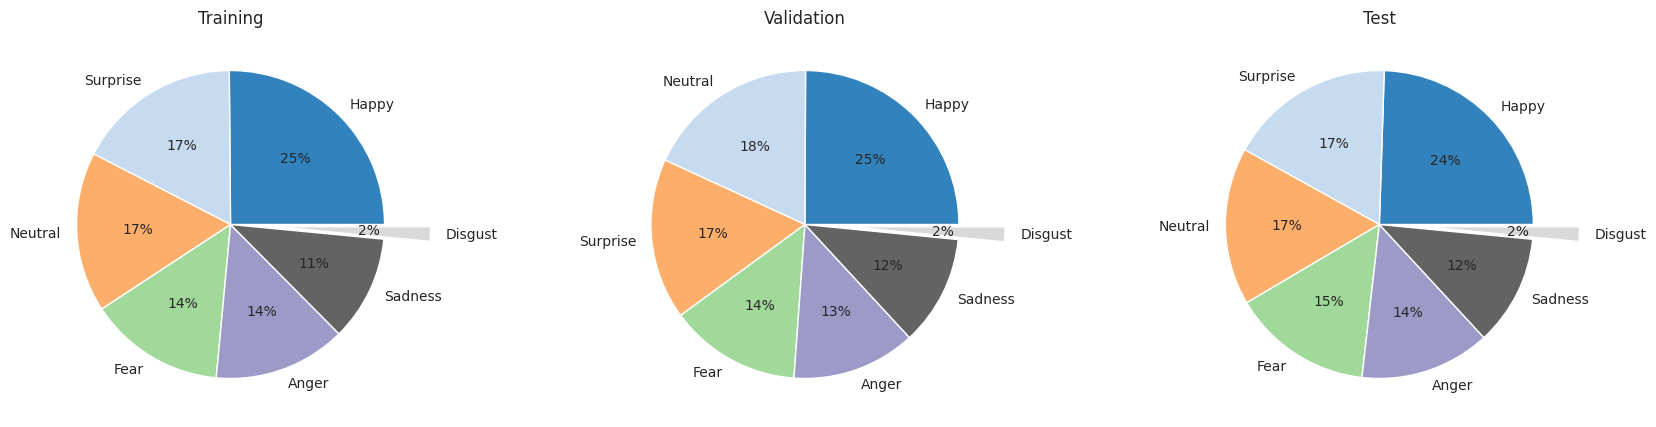

In [11]:
explode = 6*[0] + [0.3]
cmap = plt.get_cmap('tab20c')
values = np.linspace(0, 1, 7)
colors = cmap(values)

fig, axs = plt.subplots(ncols=3, figsize=(21,5))

data[data.Usage == 'Training'].replace(class_dict)['emotion'].value_counts(normalize=True).plot.pie(ax=axs[0], ylabel='', autopct='%.0f%%', explode = explode, colors=colors)
data[data.Usage == 'PublicTest'].replace(class_dict)['emotion'].value_counts(normalize=True).plot.pie(ax=axs[1], ylabel='', autopct='%.0f%%', explode = explode, colors=colors)
data[data.Usage == 'PrivateTest'].replace(class_dict)['emotion'].value_counts(normalize=True).plot.pie(ax=axs[2], ylabel='', autopct='%.0f%%', explode = explode, colors=colors)

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

## Model: CNN

1. **Visualization Functions:**
   - `plot_metrics(history)`: Plots training and validation metrics over epochs using Matplotlib.
   - `plot_confusion_matrix(y_pred_labels, test_image_array)`: Visualizes confusion matrices for highest and second-highest predicted labels using Seaborn and Matplotlib.
   - `print_metrics(labels, predictions)`: Prints evaluation metrics like LogLoss, Accuracy, Precision, and Recall.

2. **Model Construction:**
   - `make_model(input_shape, num_classes, metrics, learning_rate)`: Defines a CNN model using Keras with data augmentation layers, convolutional layers, max-pooling, dense layers, and softmax activation.
   - Custom metrics include Mean Squared Error, Binary Accuracy, Precision, Recall, AUC, and AUC for the precision-recall curve.

3. **Training and Evaluation:**
   - Creates an EarlyStopping callback to prevent overfitting during training.
   - Defines hyperparameters such as epochs and batch size.
   - Trains the model using training and validation data, employing the EarlyStopping callback.
   - Makes predictions on validation and test datasets.
   - Calls visualization functions to display training metrics, confusion matrices, and prints evaluation metrics.

### Visualisation Functions

In [12]:
def plot_metrics(history):
    """
    Plots training and validation metrics over epochs.

    Parameters:
    - history: A Keras history object containing training and validation metrics.

    Returns:
    - None
    """
    # Get the number of metrics
    N = len(list(history.history.keys()))

    # Create subplots
    fig, axs = plt.subplots(ncols=N // 2, figsize=(21, 3))
    axs = axs.flatten()

    # Plot each metric
    for idx, metric in enumerate(list(history.history.keys())[:N // 2]):
        axs[idx].plot(history.history[metric])
        axs[idx].plot(history.history[f'val_{metric}'])

        axs[idx].set_title(metric)
        axs[idx].set_xlabel('Epoch')
        axs[idx].legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()

def plot_confusion_matrix(y_pred_labels, test_image_array, second_highest_indices):
    """
    Plots confusion matrices for the highest and second-highest predicted labels.

    Parameters:
    - y_pred_labels: Predicted labels
    - test_image_array: True labels
    - second_highest_indices: Second most guessed emotion

    Returns:
    - None
    """

    # Create confusion matrices
    conf_matrix = confusion_matrix(test_image_label, y_pred_labels)
    conf_matrix_secondhighest = confusion_matrix(test_image_label, second_highest_indices)

    # Calculate precision and recall for each emotion
    TP_per_emotion = np.diag(conf_matrix)
    FP_per_emotion = np.sum(conf_matrix, axis=0) - TP_per_emotion
    FN_per_emotion = np.sum(conf_matrix, axis=1) - TP_per_emotion
    precision_per_emotion = TP_per_emotion/(TP_per_emotion + FP_per_emotion)
    recall_per_emotion = TP_per_emotion/(TP_per_emotion + FN_per_emotion)
    accuracy_per_emotion = TP_per_emotion / (TP_per_emotion + FP_per_emotion + FN_per_emotion)
    class_fraction = conf_matrix/conf_matrix.sum(axis=1)[:,None]

    # Create subplots
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # Plot confusion matrix for the highest predicted label
    sns.heatmap(conf_matrix, annot=class_fraction, fmt='0.2f', cmap='Reds', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidth=0.5,
                ax=axs[0])

    for i in range(len(class_labels)):
        axs[0].text(7.5, i + 0.5, f'P: {precision_per_emotion[i]:0.2f}\nR: {recall_per_emotion[i]:0.2f}\nAcc: {accuracy_per_emotion[i]:0.2f}',
             ha='center', va='center', fontsize=8)

    axs[0].xaxis.set_ticks_position('top')
    axs[0].xaxis.set_label_position('top')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_title('Confusion Matrix: Highest')

    class_fraction_secondhighest = conf_matrix_secondhighest/conf_matrix_secondhighest.sum(axis=1)[:,None]

    # Plot confusion matrix for the second-highest predicted label
    sns.heatmap(conf_matrix_secondhighest, annot=class_fraction_secondhighest, fmt='0.2f', cmap='Reds', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidth=0.5,
                ax=axs[1])
    axs[1].xaxis.set_ticks_position('top')
    axs[1].xaxis.set_label_position('top')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')
    axs[1].set_title('Confusion Matrix: Second Highest')

    plt.tight_layout()

def print_metrics(labels, predictions):
    """
    Prints evaluation metrics.

    Parameters:
    - labels: True labels
    - predictions: Predicted labels

    Returns:
    - str: Formatted string containing evaluation metrics
    """
    predictions_labels = np.argmax(predictions, axis=1)
    return (f"LogLoss: {log_loss(labels, predictions):0.4f} \
              Accuracy: {accuracy_score(labels, predictions_labels):0.4f} \
              Precision: {precision_score(labels, predictions_labels, average='macro'):0.4f} \
              Recall: {recall_score(labels, predictions_labels, average='macro'):0.4f}")


### Model Construction/Training/Evaluation

Restoring model weights from the end of the best epoch: 85.
Epoch 95: early stopping
113/113 [==============================] - 1s 5ms/step
Validation: LogLoss: 1.0514               Accuracy: 0.6342               Precision: 0.6210               Recall: 0.6126
Test: LogLoss: 0.9970               Accuracy: 0.6489               Precision: 0.6257               Recall: 0.6417


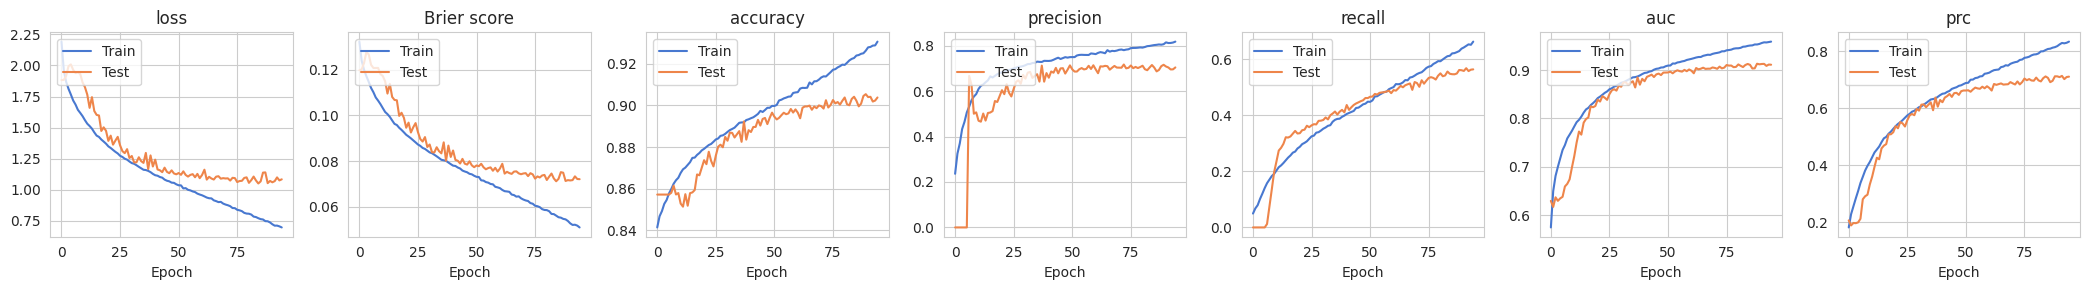

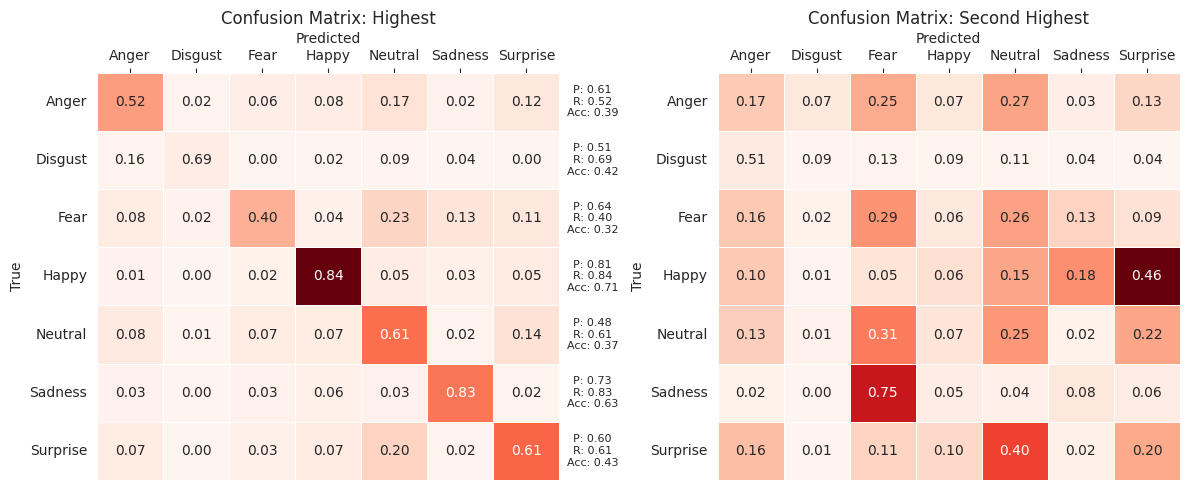

In [13]:
# Function to create and compile a Convolutional Neural Network (CNN) model
def make_model(input_shape=(48, 48, 1),
               num_classes=7,
               metrics=['accuracy'],
               learning_rate=1e-4):
    """
    Create and compile a CNN model for image classification.

    Parameters:
    - input_shape: Tuple, shape of input images.
    - num_classes: Integer, number of output classes.
    - metrics: List of metrics to monitor during training.
    - learning_rate: Float, learning rate for the optimizer.

    Returns:
    - Keras model: Compiled CNN model.
    """

    # Initialising the CNN
    model = keras.models.Sequential()

    # Data augmentation layers
    #model.add(keras.layers.RandomFlip("horizontal", input_shape=input_shape))
    #model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1))
    #model.add(keras.layers.RandomContrast(factor=0.1))

    # 1 - Convolution
    model.add(keras.layers.Conv2D(64,(3,3), padding='same', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # 2nd Convolution layer
    model.add(keras.layers.Conv2D(128,(5,5), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # 3rd Convolution layer
    model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # 4th Convolution layer
    model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # Flattening
    model.add(keras.layers.Flatten())

    # Fully connected layer 1st layer
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model with specified optimizer, loss function, and metrics
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=METRICS)  # Metrics defined below

    return model


# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your preference
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore weights from the epoch with the best value
    verbose=1
)

# Custom metrics for model evaluation
METRICS = [
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

# Create the CNN model using make_model function
model = make_model(input_shape=input_shape,
                   num_classes=num_classes,
                   metrics=METRICS)

# Display the model summary
# model.summary()

EPOCHS = 200
BATCH_SIZE = 512

# Train the model with early stopping
history = model.fit(train_image_array, y_train_one_hot,
                    validation_data=(val_image_array, y_val_one_hot),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=0)

# Make predictions on validation and test datasets
y_pred_val = model.predict(val_image_array)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

y_pred = model.predict(test_image_array)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the second-highest predicted label indices on validation and test datasets
sorted_indices = np.argsort(y_pred, axis=1)[:, ::-1]
second_highest_indices = sorted_indices[:, 1]

# Visualize training metrics and confusion matrix
plot_metrics(history)
plot_confusion_matrix(y_pred_labels, test_image_array, second_highest_indices)

# Print evaluation metrics for validation and test datasets
print(f'Validation: {print_metrics(val_image_label, y_pred_val)}')
print(f'Test: {print_metrics(test_image_label, y_pred)}')


**Explaination of Confusion Matrix:**

* **Color**: number of cases in that bin
* **Annotation**: what fraction of images belonging to a particular emotion, in that bin
* **P, R, Acc:** Emotion-specific precision, recall and accuracy

Left Confusion Matrix: Predicted label vs True label


Right Confusion Matrix: Second-highest predicted label vs True label [what label is most confused with the true label?]

## Performance

Metrics:
* Accuracy: 0.6492               
* Precision: 0.6267               
* Recall: 0.6404



Best/Worst emotions (Accuracy):
* Best emotion: Happy
* Worst emotion: Fear

## Save model

In [15]:
model.save('emotion_classifier.h5')
#model.save('../models/emotion_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Model

In [16]:
model = keras.models.load_model('emotion_classifier.h5')
#model = keras.models.load_model('../models/emotion_classifier.h5')

## Predictions

* Load a test image
* Preprocess test image
* Make prediction using loaded model
* Calculate class probabilities and top prediction

In [17]:
img = load_img("/content/drive/MyDrive/test_image_anger.jpg", target_size=(48, 48))
#img = load_img("../scripts/test_image_anger.jpg", target_size=(48, 48))
true_test_label = 'anger'

In [18]:
x = np.array(img)
x = x[:,:,0]
X = np.array([x])

In [19]:
X = X/255.

In [20]:
pred = model.predict(X)

1/1 [==============================] - 1s 722ms/step


In [21]:
print(dict(zip(class_labels, pred[0])))
print(class_labels[np.argmax(pred, axis=1)[0]])


{'Anger': 0.95130104, 'Disgust': 0.024355888, 'Fear': 0.009387173, 'Happy': 0.0007736401, 'Neutral': 0.0029894235, 'Sadness': 0.00066181406, 'Surprise': 0.010531006}
Anger


## Convert Keras to TF-Lite

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('emotion_classifier.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

### Predictions using TF-lite

* Load target image and label
* Preprocess image array: 3-->1 channel + rescaling + float32 conversion + expand dimension
* Load model and weights
* Manually set input and output indices
* Initialise input, invoke computations and fetch predictions
*

In [92]:
img = load_img("/content/drive/MyDrive/test_image_anger.jpg", target_size=(48, 48))
#img = load_img("../scripts/test_image_anger.jpg", target_size=(48, 48))
true_test_label = 'anger'

In [85]:
# Convert to numpy array
x = np.array(img)

# Reduce channels from 3 to 1
x = x[:,:,0]

# Convert to list of images
X = np.array([x])

# Rescale
X = X/255.

# Convert to rank 4 float32 tensor (required for TF input)
X = np.expand_dims(np.float32(X), axis=-1)

In [87]:
# Load model
interpreter = tflite.Interpreter(model_path='emotion_classifier.tflite')

# Load weights
interpreter.allocate_tensors()

# Manually set input and output indices
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [65]:
#interpreter.get_input_details()
#interpreter.get_output_details()

In [89]:
# Initialise intput
interpreter.set_tensor(input_index, X)

# Invoke computations
interpreter.invoke()

# Fetch predictions
preds = interpreter.get_tensor(output_index)

In [90]:
print(dict(zip(class_labels, pred[0])))
print(class_labels[np.argmax(pred, axis=1)[0]])

{'Anger': 0.95130104, 'Disgust': 0.024355888, 'Fear': 0.009387173, 'Happy': 0.0007736401, 'Neutral': 0.0029894235, 'Sadness': 0.00066181406, 'Surprise': 0.010531006}
Anger


## Remove TF dependency

In the above code, the only TF dependency we use is:

```
from tensorflow.keras.preprocessing.image import load_img
img = load_img("/content/drive/MyDrive/test_image_anger.jpg", target_size=(48, 48))
```

We can replace this dependency through the use of `PIL`. The rest of the code remains the same.


In [96]:
from PIL import Image

img = Image.open("/content/drive/MyDrive/test_image_anger.jpg")
#img = Image.open("../scripts/test_image_anger.jpg")
true_test_label = 'anger'


In [101]:
# Convert to numpy array
x = np.array(img)

# Convert to list of images
X = np.array([x])

# Rescale
X = X/255.

# Convert to rank 4 float32 tensor (required for TF input)
X = np.expand_dims(np.float32(X), axis=-1)

In [ ]:

# Convert to numpy array
x = np.array(img)

# Reduce channels from 3 to 1
x = x[:,:,0]

# Convert to list of images
X = np.array([x])

# Rescale
X = X/255.

# Convert to rank 4 float32 tensor (required for TF input)
X = np.expand_dims(np.float32(X), axis=-1)


In [102]:
# Initialise intput
interpreter.set_tensor(input_index, X)

# Invoke computations
interpreter.invoke()

# Fetch predictions
preds = interpreter.get_tensor(output_index)

In [103]:
print(dict(zip(class_labels, pred[0])))
print(class_labels[np.argmax(pred, axis=1)[0]])

{'Anger': 0.95130104, 'Disgust': 0.024355888, 'Fear': 0.009387173, 'Happy': 0.0007736401, 'Neutral': 0.0029894235, 'Sadness': 0.00066181406, 'Surprise': 0.010531006}
Anger


## Summary and Conclusions

In this project, we developed a Convolutional Neural Network (CNN) model for facial expression recognition using the FER2013 dataset. The model was trained on a diverse set of emotions, including Anger, Disgust, Fear, Happy, Neutral, Sadness, and Surprise. The training process involved data preparation, model architecture design, and evaluation metrics definition.

The CNN model demonstrated promising performance on both the validation and test datasets, as indicated by metrics such as accuracy, precision, recall, and log loss. The inclusion of early stopping helped prevent overfitting and ensured the selection of the best model weights during training. Finally, with a view to do a light-weight deployment, we convert the Keras model to a TF-Lite model and remove all Tensorflow dependency in the prediction framework.

The project serves as a foundation for further exploration and refinement of facial expression recognition models. Future work may involve fine-tuning hyperparameters, exploring additional data augmentation techniques, and optimizing the model for real-world applications. The trained model has been saved for potential deployment and can be found in the 'models' directory.
